In [1]:
import torch
import torch.nn as nn
from torch.func import jacrev, jacfwd, vmap

import numpy as np
import matplotlib.pyplot as plt # need 3.10 plus for "berlin" cmap
import matplotlib.colors as mcolors

from simulate import simulate_convergence, simulate_merge, simulate_branching, simulate_deflection, simulate_ridge
from visualise import visualise_v_quiver, visualise_v_stream
from NN_models import dfNN_for_vmap

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [ ]:
model = dfNN_for_vmap()

# parse one point
print(model(torch.tensor([1.0, 0.5]))) 

# parse two points
print(vmap(model)(torch.tensor([[1.0, 0.5], [0.5, 1.0]])))

tensor([-0.0910, -0.0147], grad_fn=<SumBackward1>)
tensor([[-0.0910, -0.0147],
        [-0.0671,  0.0388]], grad_fn=<SumBackward1>)


In [2]:
# overwrite with 20 * 20 grid
N = 20 * 20 # N should be a perfect square
N_side = int(N ** 0.5)

dims = 2

# inputs = torch.randn(N, dims)  # Random (N, 2) inputs
xy_side = torch.linspace(0, 1, N_side)
# torch meshgrid, not default but we want to index by x, y
X_mesh, Y_mesh = torch.meshgrid(xy_side, xy_side, indexing = "xy")

# Construct flat pairs of points
# now the span [0, 3]
x_test = torch.cat([X_mesh.reshape(-1, 1), Y_mesh.reshape(-1, 1)], dim = 1)
print(x_test.shape)

torch.Size([400, 2])


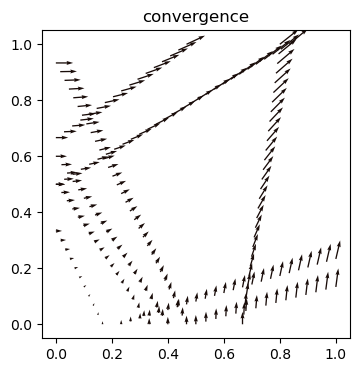

In [3]:
# float32 is default for
x_train = torch.load("data/sim_data/x_train_lines_discretised_0to1.pt", weights_only = True).float().requires_grad_()
# x_train = inputs_03
y_train = simulate_convergence(x_train).float()

visualise_v_quiver(y_train.detach(), x_train.detach(), title_string = "convergence")

# Develop without vmap

In [ ]:
class dfNN(nn.Module):
    def __init__(self, input_dim = 2, hidden_dim = 32):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = 1  # Scalar potential

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.output_dim)
        )

    def forward(self, x):
        """
        Turn x1, x2 locations into vector fields
        x: [batch_size, input_dim]
        Returns: [batch_size, input_dim]  # Symplectic gradient
        """
        # Retrieve scalar potential
        H = self.net(x)

        partials = torch.autograd.grad(
                outputs = H.sum(), # we can sum here because every H row only depend on every x row
                inputs = x,
                create_graph = True
            )[0]
        
        # flip columns (last dim)
        symp = partials.flip(-1) * torch.tensor([1, -1], dtype = torch.float32)

        return symp

model = dfNN()
p = model(x_train)

In [23]:
# Convert to DataLoader for batching
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

# Initialise fresh model
model = dfNN()
model.train()

# Define loss function (e.g., MSE for regression)
criterion = nn.MSELoss()

# Define optimizer (e.g., Adam)
optimizer = optim.AdamW(model.parameters(), lr = 0.0001, weight_decay = 1e-4)
num_epochs = 3000

# Initialise tensor to store losses
epoch_losses = torch.zeros(num_epochs)

print()
print("Start Training")
for epoch in range(num_epochs):

    epoch_loss = 0.0  # Accumulate batch losses

    for batch in dataloader:
        x_batch, y_batch = batch
        x_batch.requires_grad_()

        y_pred = model(x_batch)

        # Compute loss: RMSE
        loss = torch.sqrt(criterion(y_pred, y_batch))
        epoch_loss += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Store the average loss for the epoch
    epoch_losses[epoch] = epoch_loss / len(dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss (RMSE): {loss.item():.4f}")


Start Training
Epoch 1/3000, Training Loss (RMSE): 0.5202
Epoch 2/3000, Training Loss (RMSE): 0.3571
Epoch 3/3000, Training Loss (RMSE): 0.6253
Epoch 4/3000, Training Loss (RMSE): 0.4330
Epoch 5/3000, Training Loss (RMSE): 0.4902
Epoch 6/3000, Training Loss (RMSE): 0.4531
Epoch 7/3000, Training Loss (RMSE): 0.4423
Epoch 8/3000, Training Loss (RMSE): 0.4157
Epoch 9/3000, Training Loss (RMSE): 0.3981
Epoch 10/3000, Training Loss (RMSE): 0.4120
Epoch 11/3000, Training Loss (RMSE): 0.5355
Epoch 12/3000, Training Loss (RMSE): 0.5720
Epoch 13/3000, Training Loss (RMSE): 0.3780
Epoch 14/3000, Training Loss (RMSE): 0.5059
Epoch 15/3000, Training Loss (RMSE): 0.5808
Epoch 16/3000, Training Loss (RMSE): 0.4761
Epoch 17/3000, Training Loss (RMSE): 0.2023
Epoch 18/3000, Training Loss (RMSE): 0.4762
Epoch 19/3000, Training Loss (RMSE): 0.3782
Epoch 20/3000, Training Loss (RMSE): 0.3616
Epoch 21/3000, Training Loss (RMSE): 0.4152
Epoch 22/3000, Training Loss (RMSE): 0.4397
Epoch 23/3000, Training L

In [35]:
# Convert to DataLoader for batching
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

# Initialise fresh model
model_v = dfNN_for_vmap()
model_v.train()

# Define loss function (e.g., MSE for regression)
criterion = nn.MSELoss()

# Define optimizer (e.g., Adam)
optimizer = optim.AdamW(model_v.parameters(), lr = 0.0001, weight_decay = 1e-4)
num_epochs = 300

# Initialise tensor to store losses
epoch_losses = torch.zeros(num_epochs)

print()
print("Start Training")
for epoch in range(num_epochs):

    epoch_loss = 0.0  # Accumulate batch losses

    for batch in dataloader:
        x_batch, y_batch = batch
        x_batch.requires_grad_()

        y_pred = vmap(model_v)(x_batch)

        # Compute loss: RMSE
        loss = torch.sqrt(criterion(y_pred, y_batch))
        epoch_loss += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Store the average loss for the epoch
    epoch_losses[epoch] = epoch_loss / len(dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss (RMSE): {loss.item():.4f}")


Start Training
Epoch 1/300, Training Loss (RMSE): 0.4397
Epoch 2/300, Training Loss (RMSE): 0.4615
Epoch 3/300, Training Loss (RMSE): 0.3981
Epoch 4/300, Training Loss (RMSE): 0.3544
Epoch 5/300, Training Loss (RMSE): 0.4416
Epoch 6/300, Training Loss (RMSE): 0.3136
Epoch 7/300, Training Loss (RMSE): 0.5819
Epoch 8/300, Training Loss (RMSE): 0.5303
Epoch 9/300, Training Loss (RMSE): 0.4413
Epoch 10/300, Training Loss (RMSE): 0.5813
Epoch 11/300, Training Loss (RMSE): 0.2758
Epoch 12/300, Training Loss (RMSE): 0.5373
Epoch 13/300, Training Loss (RMSE): 0.4089
Epoch 14/300, Training Loss (RMSE): 0.4428
Epoch 15/300, Training Loss (RMSE): 0.2508
Epoch 16/300, Training Loss (RMSE): 0.3650
Epoch 17/300, Training Loss (RMSE): 0.2673
Epoch 18/300, Training Loss (RMSE): 0.4542
Epoch 19/300, Training Loss (RMSE): 0.5661
Epoch 20/300, Training Loss (RMSE): 0.3060
Epoch 21/300, Training Loss (RMSE): 0.4287
Epoch 22/300, Training Loss (RMSE): 0.4879
Epoch 23/300, Training Loss (RMSE): 0.2203
Epoc

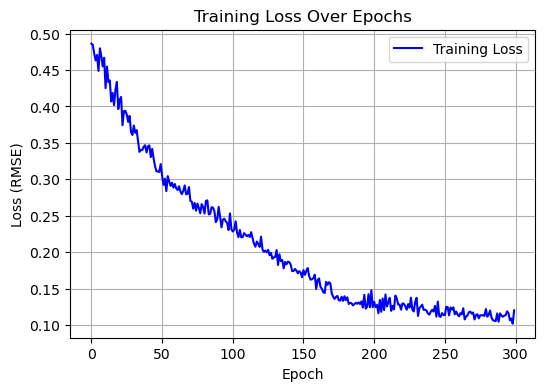

In [36]:
plt.figure(figsize = (6, 4))
plt.plot(epoch_losses.numpy(), label = "Training Loss", color = "b")
plt.xlabel("Epoch")
plt.ylabel("Loss (RMSE)")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

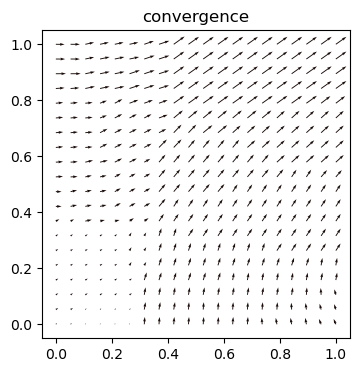

tensor(0.1409, grad_fn=<SqrtBackward0>)

In [38]:
model_v.eval()
pred = vmap(model_v)(x_test)

from metrics import compute_RMSE

visualise_v_quiver(pred.detach(), x_test, title_string = "convergence")

compute_RMSE(pred, simulate_convergence(x_test))

In [39]:
# Functional divergence
torch.diagonal(vmap(jacrev(model_v))(x_train), dim1 = 1, dim2 = 2).sum(0)

tensor([0., 0.], grad_fn=<SumBackward1>)